# ITCS 3162 - Assignment 2

Frequent Itemset Mining - A Priori Algorithm

### Name: 

### Submission instructions

- Enter your name in the space above.  
- Save your completed json as *itcs3162_assignment_2_**\<uncc username>**.ipynb*.
- Upload **both** the **ipynb** file and the **html** file version of your completed notebook to Canvas.  

You can download the notebook in html format by going to *File --> Download as --> HTML*

***

## Mining Frequent Hashtags on Twitter

For this assignment, you will implement the *a priori* algorithm to mine pairs of hashtags that co-occur frequently in a set of tweets scraped using Twitter's API.

The "baskets" of hashtags are provided in the included data file **hashtag_baskets.csv**. Please download the file from Canvas and put the file in the **same directory** as this Jupyter notebook.

The function provided below will read the data file in as a list of sets of hashtags. Each set of hashtags corresponds to all the hashtags used in a single tweet.

In [1]:
def load_hashtags():
    with open('hashtag_baskets.csv') as f:
        return [
            set(line.strip().split(','))
            for line in f
        ]

In [2]:
hashtag_baskets = load_hashtags()
hashtag_baskets[:10]  # Print the first few hashtags

[{'COVID19', 'StayHomeSaveLives'},
 {'recallgavinnewsom'},
 {'stayhome'},
 {'MondayMotivation'},
 {'Economy', 'POTUS'},
 {'BackToWorkNOW', 'NaziNationState', 'OperationGridlock', 'overreach'},
 {'STFH'},
 {'COVID19', 'GavinNewsom', 'KamalaHarris', 'coronavirus'},
 {'protectLA', 'protectcalifornua', 'thankyouforyourservice'},
 {'CARESAct', 'edd', 'eddpenaltyweeks'}]

## Part 1 - Frequent items (25 pts)

In the cells below:
1. Define a function that takes in a *list of item baskets* and a *support threshold*. The function should **return the frequent items**  
    (You may also want to return the count of each hashtag along with the tag itself)
2. Use your function to find the frequently occurring hashtags in our dataset
3. Print out your support threshold and the total number of hashtags that occur frequently
4. Print the **top 10** most frequent hashtags sorted by support

In [3]:
from collections import Counter, defaultdict

def count_freq_items(baskets, min_support=1):
    # Step 1: Count how many times each hashtag occurs
    # Option 1: dictionary
    item_counts = {}
    for basket in baskets:
        for item in basket:
            if item in item_counts:
                item_counts[item] += 1
            else:
                item_counts[item] = 1
    
    # Option 2: defaultdict
    item_counts = defaultdict(int)
    for basket in baskets:
        for item in basket:
            item_counts[item] += 1
    
    # Option 3: Counter
    item_counts = Counter(
                    item
                    for basket in baskets
                    for item in basket
                )

    # Step 2: Keep only hashtags that occur at or above our support threshold
    freq_items = {
        item: count
        for item, count in item_counts.items()
        if count >= min_support
    }
    
    return freq_items

Determine which support threshold to use based on the "elbow" curve

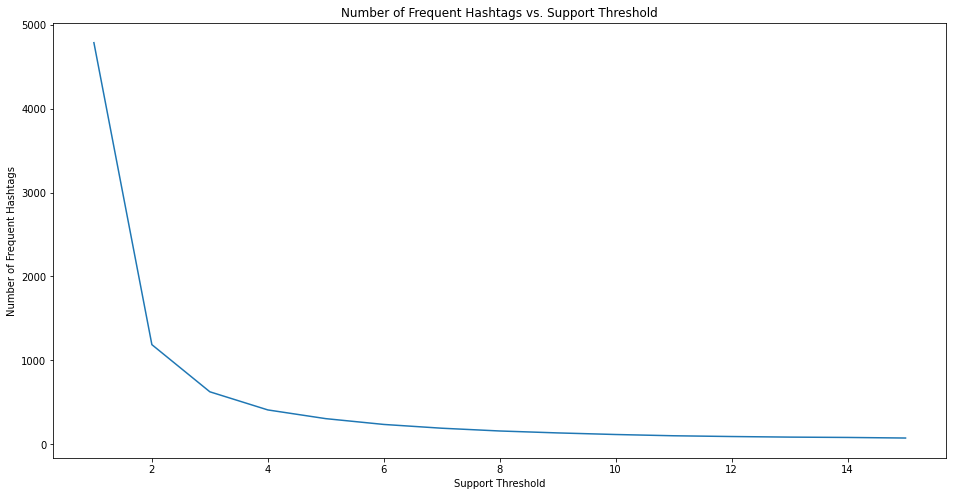

In [4]:
import matplotlib.pyplot as plt

hashtag_counts = count_freq_items(hashtag_baskets)

support_range = list(range(1, 16))
freq_item_num = [
    sum(count >= support for count in hashtag_counts.values())  # Count number of frequent hashtags for different thresholds
    for support in support_range
]

plt.figure(figsize=(16, 8))
plt.plot(support_range, freq_item_num)
plt.ylabel('Number of Frequent Hashtags')
plt.xlabel('Support Threshold')
plt.title('Number of Frequent Hashtags vs. Support Threshold')
plt.show()

In [5]:
support = 5  # Set support threshold at 5 from the "elbow" curve
freq_hashtags = count_freq_items(hashtag_baskets, support)

In [6]:
print(f'Support Threshold: {support}')
print(f'Number of frequent hashtags: {len(freq_hashtags)}')

Support Threshold: 5
Number of frequent hashtags: 305


In [7]:
for hashtag, count in sorted(freq_hashtags.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(hashtag, count)

COVID19 577
RecallGavinNewsom 409
OpenCalifornia 201
opencalifornianow 195
California 171
coronavirus 169
StayHomeSaveLives 138
AB5 132
COVID-19 107
StayHome 71


## Part 2 - Generate candidates (15 pts)

Using your results from Part 1, generate the candidate pairs of hashtags

In [8]:
from itertools import combinations

def generate_candidate_pairs(freq_items):
    return list(combinations(freq_items, 2))

In [9]:
candidate_pairs = generate_candidate_pairs(freq_hashtags)

## Part 3 - Frequent pairs (30 pts)

1. Using your candidate pairs from Part 2, count the occurrences of each candidate pair in our dataset
2. Filter based on your support threshold to find the frequent pairs of hashtags
3. Print the **top 10** frequent hashtag pairs sorted by support

In [10]:
def count_item_pairs(baskets, item_pairs, min_support):
    # Step 1: Count how many times each pair of hashtags co-occurs
    pair_counts = defaultdict(int)
    for candidate_pair in item_pairs:
        candidate_pair = frozenset(candidate_pair)  # Convert to a frozenset so we can use set() methods and use as a dict key
        for basket in baskets:
            if candidate_pair.issubset(basket):
                pair_counts[candidate_pair] += 1
        
    # Step 2: Keep only pairs that occur at or above our support threshold
    freq_pairs = {
        pair: count
        for pair, count in pair_counts.items()
        if count >= min_support
    }
    
    return freq_pairs

In [11]:
freq_hashtag_pairs = count_item_pairs(hashtag_baskets, candidate_pairs, support)

In [12]:
for hashtag_pair, count in sorted(freq_hashtag_pairs.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(hashtag_pair, count)

frozenset({'coronavirus', 'COVID19'}) 58
frozenset({'opencalifornianow', 'RecallGavinNewsom'}) 38
frozenset({'COVID19', 'StayHomeSaveLives'}) 31
frozenset({'opencalifornianow', 'OpenCalifornia'}) 31
frozenset({'RecallGavinNewsom', 'OpenCalifornia'}) 30
frozenset({'COVID', 'COVID-19'}) 26
frozenset({'RepealAB5', 'AB5'}) 24
frozenset({'COVID', 'Coronavirus'}) 23
frozenset({'Coronavirus', 'COVID-19'}) 23
frozenset({'SARS_COV_2', 'SARSCoV2'}) 23


## Part 4 - Association Rules (30 pts)

Using your results from Part 1 and Part 3, find the association rules with high confidence.

1. For each frequent pair, derive the **two** association rules from that pair and compute the **confidence** of each rule
2. Filter the association rules based on a confidence threshold of your choosing
3. Print each association rule and its confidence value

In [13]:
def association_rules(item_counts, pair_counts, min_confidence):
    
    # Helper function to do confidence computation
    def confidence(pair_support, item_support):
        return pair_support / item_support
    
    # Step 1: Generate rules and compute confidence value for each rule
    # For each set {a, b}, there are two association rules
    # 1. If {a}, then {b}
    # 2. If {b}, then {a}
    assoc_rules = {}
    for pair, pair_support in pair_counts.items():
        item_a, item_b = pair
        assoc_rules[f'{item_a} --> {item_b}'] = confidence(pair_support, item_counts[item_a])
        assoc_rules[f'{item_b} --> {item_a}'] = confidence(pair_support, item_counts[item_b])

    # Step 2: Keep only rules that occur at or above our confidence threshold
    return {
        rule: conf
        for rule, conf in assoc_rules.items()
        if conf >= min_confidence
    }

In [14]:
confidence = 0.75
hashtag_rules = association_rules(freq_hashtags, freq_hashtag_pairs, confidence)

In [15]:
for rule, conf in sorted(hashtag_rules.items(), key=lambda x: x[1]):
    print(f'{rule}: {conf * 100:.2f}%')

fear --> COVID19: 77.78%
peace --> COVID19: 77.78%
HomeOwners --> BridgeTheBigGap: 77.78%
Fakedemic --> Plandemic: 78.95%
SARSCoV2 --> COVID19: 80.77%
Evictions --> Evicitons: 81.82%
Evictions --> HomeOwners: 81.82%
reopenparks --> reopenchildcare: 83.33%
Forclosures --> Evicitons: 83.33%
Forclosures --> Foreclosures: 83.33%
Forclosures --> NoRedTagBoxes2CheckMoratoriums: 83.33%
Forclosures --> HomeOwners: 83.33%
TakeResponsibility --> COVID19: 85.71%
Pelosi --> Newsom: 85.71%
stoplettingthemlietoyou --> AmericaFirst: 85.71%
ohthehypocrisy --> AmericaFirst: 85.71%
TakeResponsibility --> fear: 85.71%
TakeResponsibility --> peace: 85.71%
SARS_COV_2 --> COVID19: 86.96%
SuspendAuditsNowEDD --> SuspendAB5: 87.50%
CORONAVIRUSPANDEMIC --> SuspendAB5: 87.50%
SARSCoV2 --> SARS_COV_2: 88.46%
Foreclosures --> Evicitons: 90.00%
Evicitons --> Foreclosures: 90.00%
NoRedTagBoxes2CheckMoratoriums --> Evicitons: 90.00%
Evicitons --> NoRedTagBoxes2CheckMoratoriums: 90.00%
Evicitons --> Evictions: 90.00%

## Bonus (5 pts)

Repeat the above experiments after applying some text preprocessing to the data
1. Convert all text to lowercase
2. Remove all punctuation

In [16]:
import string

def clean(text):
    text = text.lower()
    return text.translate(str.maketrans('', '', string.punctuation))

In [17]:
clean_baskets = [
    set(clean(hashtag) for hashtag in basket)
    for basket in hashtag_baskets
]

In [18]:
freq_hashtags = count_freq_items(clean_baskets, support)

In [19]:
freq_hashtag_pairs = count_item_pairs(clean_baskets, generate_candidate_pairs(freq_hashtags), support)

In [20]:
hashtag_rules = association_rules(freq_hashtags, freq_hashtag_pairs, confidence)

In [21]:
for rule, conf in sorted(hashtag_rules.items(), key=lambda x: x[1]):
    print(f'{rule}: {conf * 100:.2f}%')

ab5stories --> ab5: 75.00%
evictions --> evicitons: 75.00%
evictions --> homeowners: 75.00%
fear --> covid19: 77.78%
peace --> covid19: 77.78%
fullyopenca --> recallgavinnewsom: 83.33%
reopenparks --> reopenchildcare: 83.33%
rentzero --> cancelrent: 83.33%
forclosures --> evicitons: 83.33%
evictions --> foreclosures: 83.33%
forclosures --> foreclosures: 83.33%
forclosures --> homeowners: 83.33%
evictions --> noredtagboxes2checkmoratoriums: 83.33%
forclosures --> noredtagboxes2checkmoratoriums: 83.33%
takeresponsibility --> covid19: 85.71%
pelosi --> newsom: 85.71%
stoplettingthemlietoyou --> americafirst: 85.71%
ohthehypocrisy --> americafirst: 85.71%
antibodytestnow --> antibodytest: 85.71%
takeresponsibility --> fear: 85.71%
takeresponsibility --> peace: 85.71%
mayday --> endthelockdown: 87.50%
suspendauditsnowedd --> suspendab5: 87.50%
sarscov2 --> covid19: 88.46%
openupamericanow --> recallgavinnewsom: 88.89%
foreclosures --> evicitons: 90.00%
evicitons --> foreclosures: 90.00%
hom